<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">
    Être ou ne pas être ?
</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">
    Un problème de classification binaire sur des données médicales artificelles
<br/>

---

# Présentation du challenge

## La question principale de ce challenge est :

* Comment prédire la survie d'un·e patient·e compte tenu de son dossier médical ?
    
* Plus précisément, vous devrez prédire la survie des patient·e·s pendant leur séjour à l'hôpital

Chaque jour, le personnel soignant collecte de nombreuses informations sur les patient·e·s en posant des questions et en utilisant des outils de mesure (stéthoscope, analyse de sang, capteurs, etc.). Ces données sont très utiles pour surveiller l'état de santé, diagnostiquer et choisir les traitements.

Elles peuvent également être utilisées pour l'analyse statistique prédictive.

## Données

L'ensemble de données contient des informations sur 80'000 patient·e·s, représentés par des variables (descripteurs) catégorielles, binaires et numériques. Ces variables sont, par exemple, l'âge, le sexe, l'origine ethnique, l'état matrimonial, ainsi que des données médicales telles que la tension artérielle ou le taux de glucose. Il y a un total de 342 variables.

La classe (étiquette ou label) à prédire est une variable binaire indiquant si la·le patient·e est décédé·e ou non pendant son séjour à l'hôpital. Heureusement, la plupart survivent :


# Challenge

In [1]:
import platform
from datetime import datetime
from pathlib import Path

import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import warnings
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
    feature_selection,
    neighbors,
)

In [2]:
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.3g}".format

sns.set_style("darkgrid")
sns.set_context("notebook")

print(pd.__version__)       # 2.0.0
print(sklearn.__version__)  # 1.2.2

2.0.2
1.2.2


## 1. Compréhension du problème

Dans les problèmes de classifications imbalancées l'exactitude (accurarcy) n'est pas efficace pour mesurer la performance du modèle car dans un ensemble de données ou une catégorie A domine de 99%, si on prédit que tout les événements sont de type A on aura 99% d'exactitude meme si tout ces événements sont d'autres types, mais par contre si on mesure d'autre indicateurs comme la précision(precision) ou le rappel (recall) on trouve de faibles valeurs, car ces dex derniers indicateurs prennent en considération le type de la classe prédite et la correctitude de la prédiction par contre l'indicateur d'exactitude (accurarcy) ne prend en considération que la correctétude du résultat, la définition de ces trois indicateurs est la suivante: 

$$\mathrm{ACC} 
= \frac{\mathrm{TP} + \mathrm{TN}}
    {\mathrm{TP} + \mathrm{TN} + \mathrm {FP} +\mathrm {FN}}$$


$$\mathrm{PPV} 
= \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm {FP}}$$


$$\mathrm{TPR} 
= \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm {TN}}$$

## 2. Chargement des données

In [3]:
DATA = Path(
    "./public_data"
).expanduser()
# DATA = Path("public_data")

PRED_PATH = Path("Submissions")

DROP_VARS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

assert DATA.is_dir()

In [4]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_df.drop(columns=DROP_VARS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [5]:
# Filter out convergence warnings
warnings.filterwarnings("ignore")
print(x_df.shape)
print(features)
print(labels)
# Now print the column names
#for f in x_df.columns:
#    print(f)

x_df.head(3)

(79999, 337)
['SUBJECT_ID' 'HADM_ID' 'ADMITTIME' 'DISCHTIME' 'INSURANCE' 'LANGUAGE'
 'RELIGION' 'MARITAL_STATUS' 'ETHNICITY' 'GENDER' 'AGE' 'HR_MIN_DAY1'
 'HR_MAX_DAY1' 'HR_MEAN_DAY1' 'SYS_BP_MIN_DAY1' 'SYS_BP_MAX_DAY1'
 'SYS_BP_MEAN_DAY1' 'DIAS_BP_MIN_DAY1' 'DIAS_BP_MAX_DAY1'
 'DIAS_BP_MEAN_DAY1' 'MEAN_BP_MIN_DAY1' 'MEAN_BP_MAX_DAY1'
 'MEAN_BP_MEAN_DAY1' 'RESP_RATE_MIN_DAY1' 'RESP_RATE_MAX_DAY1'
 'RESP_RATE_MEAN_DAY1' 'TEMP_MIN_DAY1' 'TEMP_MAX_DAY1' 'TEMP_MEAN_DAY1'
 'SPO2_MIN_DAY1' 'SPO2_MAX_DAY1' 'SPO2_MEAN_DAY1' 'GLUCOSE_MIN_DAY1'
 'GLUCOSE_MAX_DAY1' 'GLUCOSE_MEAN_DAY1' 'HR_MIN_DAY2' 'HR_MAX_DAY2'
 'HR_MEAN_DAY2' 'SYS_BP_MIN_DAY2' 'SYS_BP_MAX_DAY2' 'SYS_BP_MEAN_DAY2'
 'DIAS_BP_MIN_DAY2' 'DIAS_BP_MAX_DAY2' 'DIAS_BP_MEAN_DAY2'
 'MEAN_BP_MIN_DAY2' 'MEAN_BP_MAX_DAY2' 'MEAN_BP_MEAN_DAY2'
 'RESP_RATE_MIN_DAY2' 'RESP_RATE_MAX_DAY2' 'RESP_RATE_MEAN_DAY2'
 'TEMP_MIN_DAY2' 'TEMP_MAX_DAY2' 'TEMP_MEAN_DAY2' 'SPO2_MIN_DAY2'
 'SPO2_MAX_DAY2' 'SPO2_MEAN_DAY2' 'GLUCOSE_MIN_DAY2' 'GLUCOSE_MAX_DAY2'

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Load test set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_test_df.drop(columns=DROP_VARS, inplace=True)

print(x_test_df.shape)
x_test_df.head(3)

(20001, 337)


,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Self_Pay,ENGL,OTHER,MARRIED,WHITE,F,18,72.6,113,96.5,...,0,0,0,0,0,0,0,0,0,0
1,Medicare,ENGL,NOT_SPECIFIED,SINGLE,BLACK/AFRICAN_AMERICAN,F,56,66.6,107,83.8,...,0,0,0,0,0,0,0,0,1,0
2,Medicaid,ENGL,CATHOLIC,SINGLE,WHITE,M,32,69.7,103,87.3,...,0,0,0,0,0,0,0,0,0,0


## 3. Analyse exploratoire

#### Types des variables

In [7]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

0
Numerical      226
Binary         107
Categorical      8
Name: count, dtype: int64

#### Distribution de la variable cible

In [8]:
ys.describe()

count   8e+04
mean    0.035
std     0.184
min         0
25%         0
50%         0
75%         0
max         1
dtype: float64

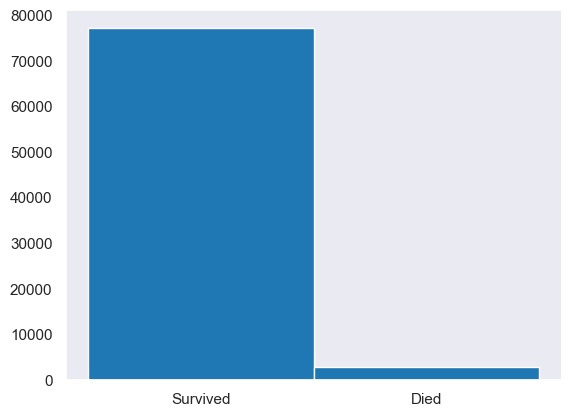

In [9]:


ys.hist(bins=2, grid=False, align="left")
plt.xticks([0, 0.5], ["Survived", "Died"])
# plt.savefig("img/tobe.png", dpi=300)
plt.show()

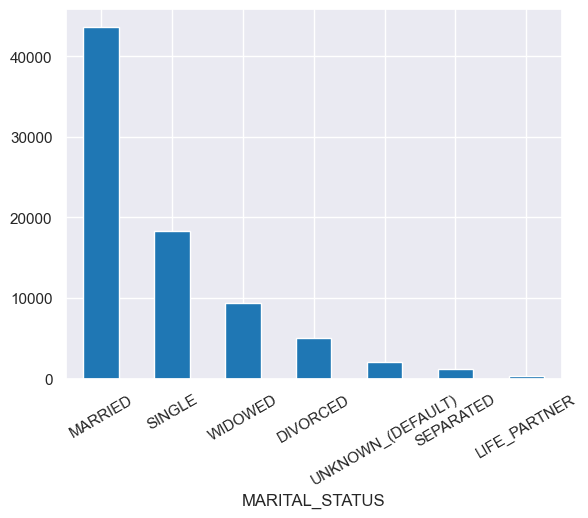

In [10]:
x_marital_cnts = x_df["MARITAL_STATUS"].value_counts()
x_marital_cnts.plot.bar(rot=30)
plt.show()

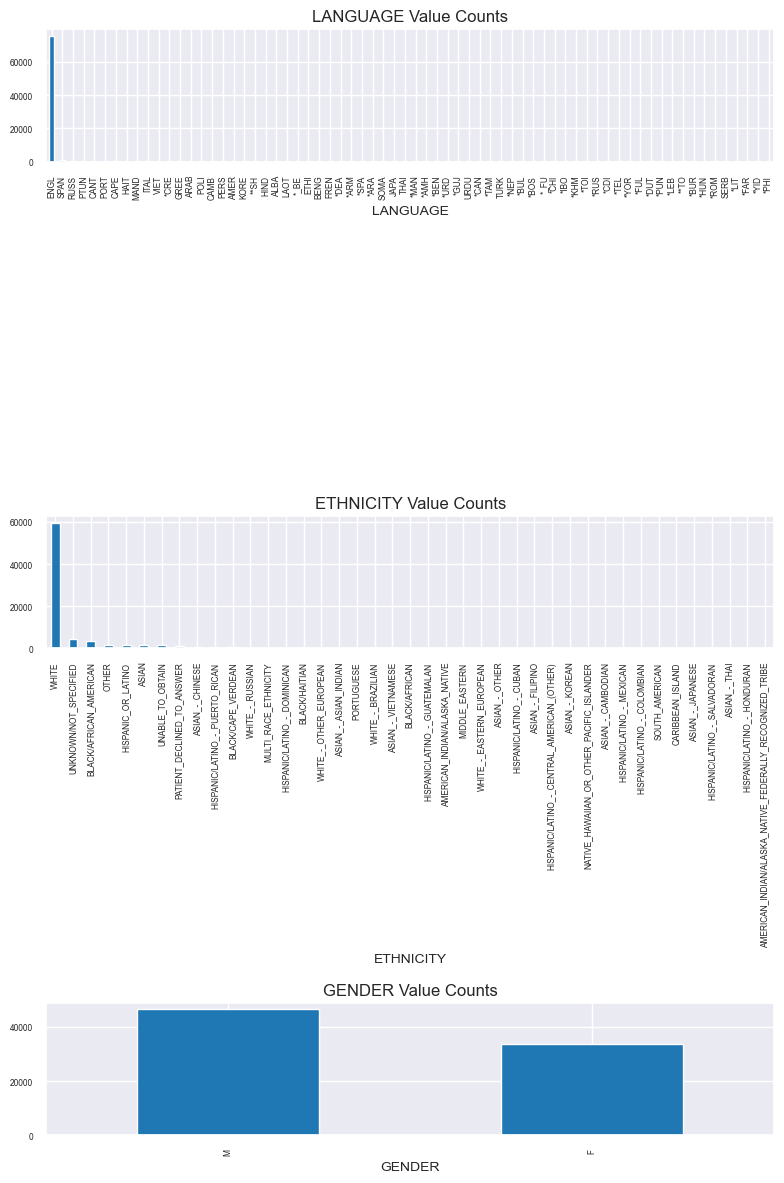

In [11]:
# Create a figure and axes for subplots
columns_to_plot=["LANGUAGE", "ETHNICITY", "GENDER"]

fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(8, len(columns_to_plot) * 4))

# Iterate over the columns and plot value counts
for i, column in enumerate(columns_to_plot):
    ax = x_df[column].value_counts().plot.bar(rot=30, ax=axes[i])
    ax.set_title(f"{column} Value Counts")
    
    # Adjust font size of x-axis and y-axis labels
    ax.set_xlabel(ax.get_xlabel(), fontsize=10)  # Set x-axis label font size
    ax.set_ylabel(ax.get_ylabel(), fontsize=10)  # Set y-axis label font size
    
    # Adjust font size of tick labels and rotate them vertically
    for tick in ax.get_xticklabels():
        tick.set_fontsize(6)  # Set font size of x-axis tick labels
        tick.set_rotation(90)  # Rotate x-axis tick labels by 90 degrees
    for tick in ax.get_yticklabels():
        tick.set_fontsize(6)  # Set font size of y-axis tick labels

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Show the plots
plt.show()


#### Corrélations

##### avant de commencer les tests de corrélation il faut qu'on converti les valeurs de type Binary ou Categorical vers des valeurs numériques, on utilisela méthode one-hot encoding

In [12]:
#Convertir les valeurs de type Categorical par la méthode one-hot encoding
x_encoded = pd.get_dummies(x_df)

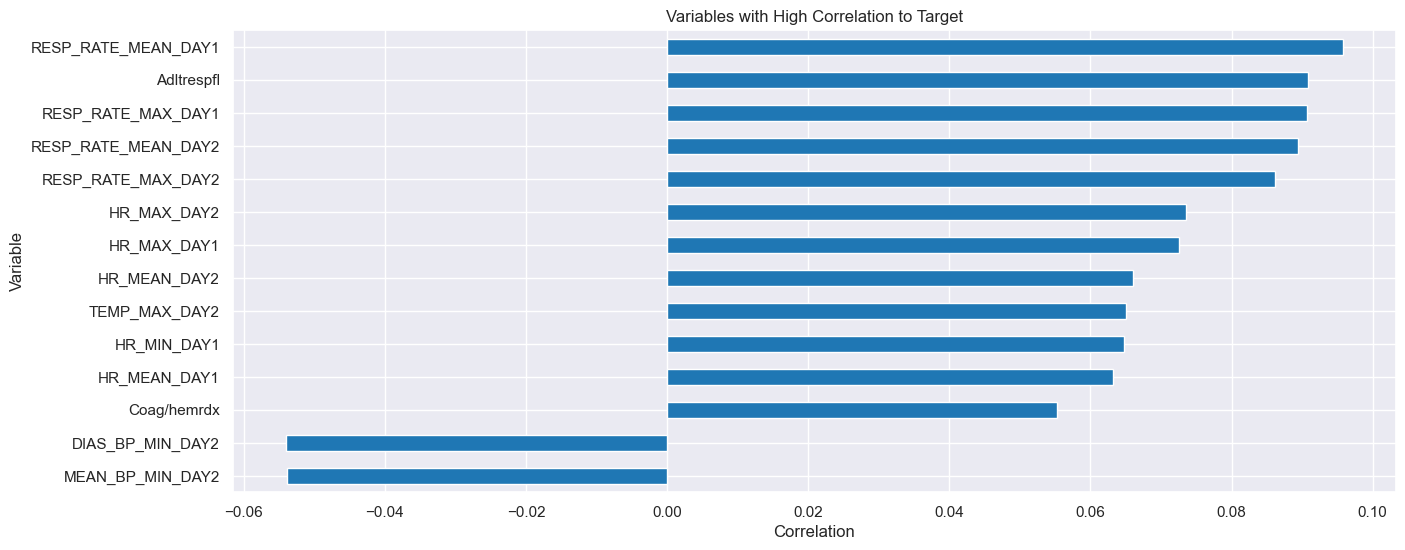

In [13]:
threshold = 0.05 

s = x_encoded.corrwith(ys, axis=0)

high_correlation_variables = s[abs(s) > threshold]

high_correlation_variables = high_correlation_variables.sort_values(key=lambda x: abs(x))

selected_variable_names = high_correlation_variables.index.tolist()

best_x_df = x_encoded[selected_variable_names]

plt.figure(figsize=(15, 6))
high_correlation_variables.plot.barh(rot=0)
plt.title('Variables with High Correlation to Target')
plt.xlabel('Correlation')
plt.ylabel('Variable')
plt.show()


<Figure size 640x480 with 0 Axes>

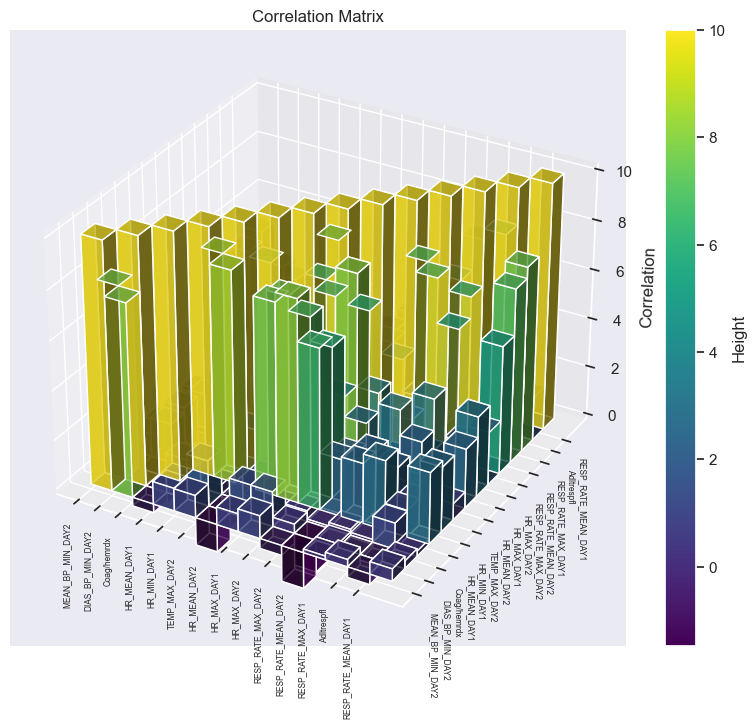

In [14]:
# Assuming you have a DataFrame x_df containing your data

# Calculate correlation matrix from x_df
correlation_matrix = best_x_df.corr()

# Create a figure and 3D axis
fig = plt.figure()
# Create a figure with a larger size
fig = plt.figure(figsize=(10, 8))  # Adjust the width and height as needed

# Add subplot with 3D axis
ax = fig.add_subplot(111, projection='3d')

# Create grid of x, y coordinates
x, y = np.meshgrid(np.arange(correlation_matrix.shape[0]), np.arange(correlation_matrix.shape[1]))

# Flatten the correlation matrix and convert correlation values to positive heights
z = correlation_matrix.values.flatten() * 10  # Adjust scaling factor as needed

# Define colormap
cmap = plt.get_cmap('viridis')

# Normalize heights to [0, 1] for colormap
norm = plt.Normalize(z.min(), z.max())

# Plot 3D bars with colored faces
bars = ax.bar3d(x.flatten(), y.flatten(), np.zeros_like(z), 1, 1, z, color=cmap(norm(z)), alpha=0.8)

# Set labels from column names of DataFrame
ax.set_xticks(np.arange(len(best_x_df.columns)))
ax.set_xticklabels(best_x_df.columns, rotation=90)
for tick in ax.get_xticklabels():
    tick.set_fontsize(6)
ax.set_yticks(np.arange(len(best_x_df.columns)))
ax.set_yticklabels(best_x_df.columns, rotation=-90)
for tick in ax.get_yticklabels():
    tick.set_fontsize(6)

# Set z-axis label
ax.set_zlabel('Correlation')

# Set title
ax.set_title('Correlation Matrix')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Height')

plt.show()

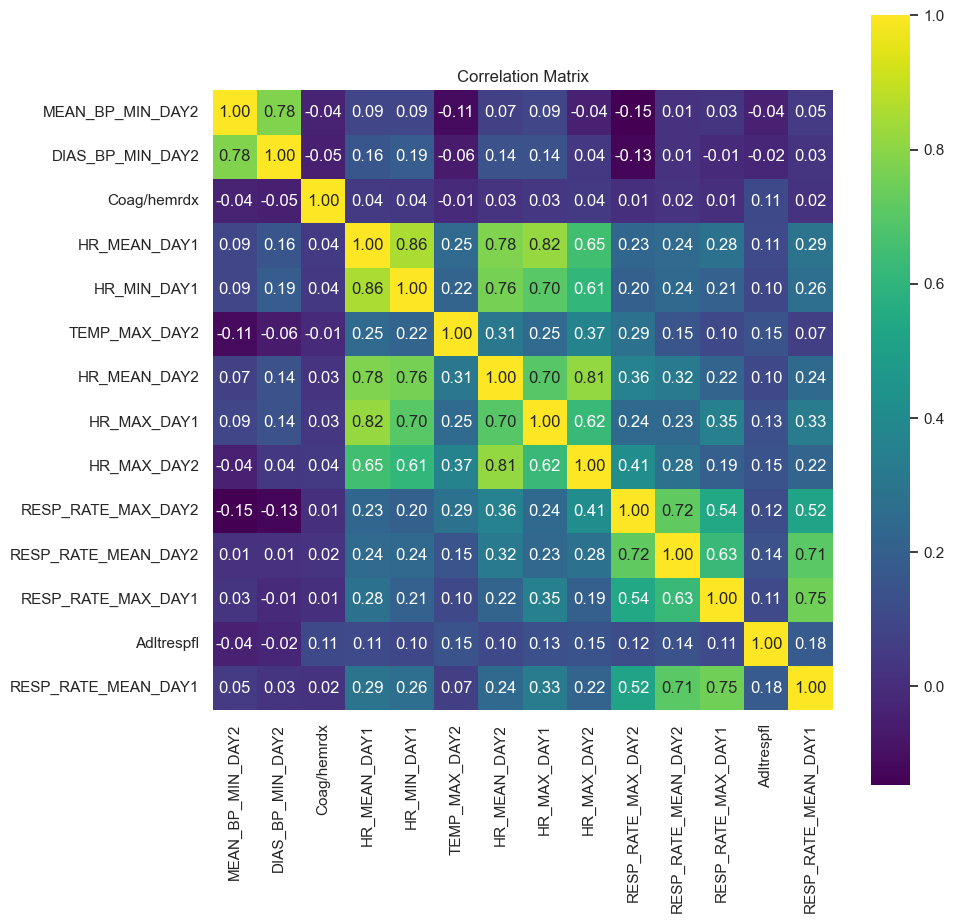

In [15]:
# Calculate correlation matrix from x_df
correlation_matrix = best_x_df.corr()

# Create a figure and axes
plt.figure(figsize=(10, 10))
# Plot heatmap with correlation values annotated
sns.heatmap(correlation_matrix, cmap='viridis', annot=True, fmt=".2f", annot_kws={"family": "Arial"}, square=True)

# Set font style
plt.rcParams['font.family'] = 'Arial'

# Set title
plt.title('Correlation Matrix')

# Show plot
plt.show()


## 4. Pre-traitement

In [16]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


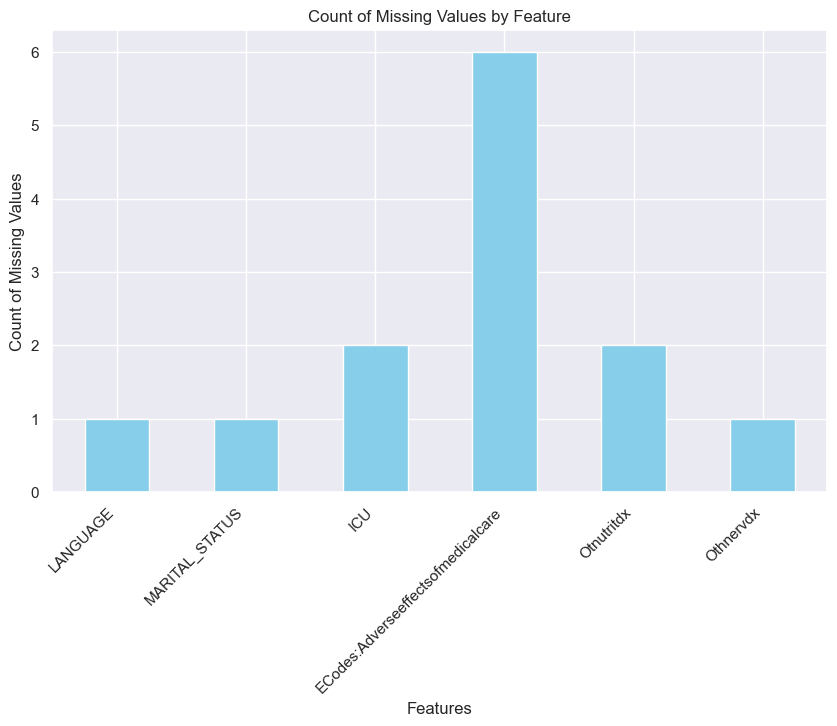

In [17]:
x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_miss

x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]

plt.figure(figsize=(10, 6))
x_miss.plot(kind='bar', color='skyblue')
plt.title('Count of Missing Values by Feature')
plt.xlabel('Features')
plt.ylabel('Count of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.show()


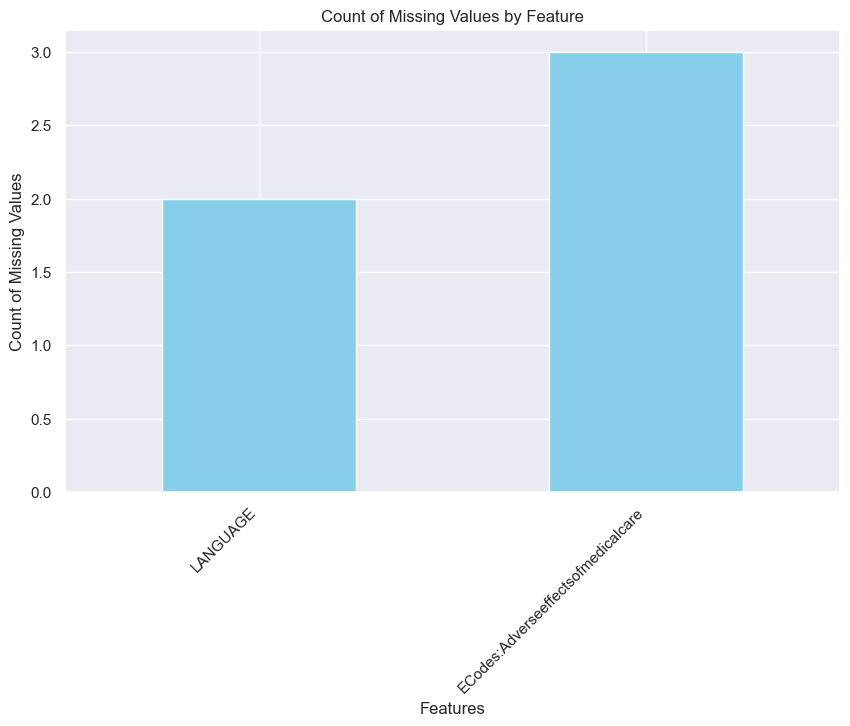

In [18]:
x_test_nans = x_test_df.isna().sum()
x_test_miss = x_test_nans[x_test_nans > 0]

plt.figure(figsize=(10, 6))
x_test_miss.plot(kind = 'bar', color='skyblue')
plt.title('Count of Missing Values by Feature')
plt.xlabel('Features')
plt.ylabel('Count of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.show()

In [19]:
x_miss_rows = x_df.isna().any(axis="columns")
x_df.loc[x_miss_rows, x_miss.index]

,LANGUAGE,MARITAL_STATUS,ICU,ECodes:Adverseeffectsofmedicalcare,Otnutritdx,Othnervdx
2251,ENGL,MARRIED,MICU,NaN,0,0
9983,ENGL,MARRIED,MICU,0,NaN,0
10549,ENGL,MARRIED,MICU,0,NaN,0
10831,ENGL,MARRIED,MICU,NaN,1,0
17012,ENGL,MARRIED,CSRU,NaN,0,1
23088,ENGL,MARRIED,NaN,0,0,0
32539,ENGL,NaN,CSRU,0,0,0
42762,ENGL,SINGLE,TSICU,NaN,0,0
53191,NaN,MARRIED,MICU,0,0,0
53390,CAPE,MARRIED,NaN,0,0,0


#### Remplacement des NAN

In [20]:
#On affiche chaque colonne avec son mode

In [21]:
na_cols = set(x_miss.index) | set(x_test_miss.index)
col_modes_train = []
col_modes_test = []

for col in na_cols:
    col_modes_train.append((col, x_df[col].mode()[0]))
    col_modes_test.append((col, x_test_df[col].mode()[0]))
    x_df[col].fillna(col_modes_train[-1][1], inplace=True)
    x_test_df[col].fillna(col_modes_test[-1][1], inplace=True)


In [22]:
print(
    x_df.isna().any().any(),
    x_test_df.isna().any().any(),
    sep="\n",
)

# Convert the arrays to pandas DataFrames
df_train_modes = pd.DataFrame(col_modes_train, columns=['Column', 'Mode (Train)'])
df_test_modes = pd.DataFrame(col_modes_test, columns=['Column', 'Mode (Test)'])

# Display the DataFrames
print("Mode values for train data:")
print(df_train_modes)

print("\nMode values for test data:")
print(df_test_modes)

x_df.loc[x_miss_rows, x_miss.index]

False
False
Mode values for train data:
                               Column Mode (Train)
0                            LANGUAGE         ENGL
1  ECodes:Adverseeffectsofmedicalcare            0
2                                 ICU         MICU
3                          Otnutritdx            0
4                           Othnervdx            0
5                      MARITAL_STATUS      MARRIED

Mode values for test data:
                               Column Mode (Test)
0                            LANGUAGE        ENGL
1  ECodes:Adverseeffectsofmedicalcare           0
2                                 ICU        MICU
3                          Otnutritdx           0
4                           Othnervdx           0
5                      MARITAL_STATUS     MARRIED


,LANGUAGE,MARITAL_STATUS,ICU,ECodes:Adverseeffectsofmedicalcare,Otnutritdx,Othnervdx
2251,ENGL,MARRIED,MICU,0,0,0
9983,ENGL,MARRIED,MICU,0,0,0
10549,ENGL,MARRIED,MICU,0,0,0
10831,ENGL,MARRIED,MICU,0,1,0
17012,ENGL,MARRIED,CSRU,0,0,1
23088,ENGL,MARRIED,MICU,0,0,0
32539,ENGL,MARRIED,CSRU,0,0,0
42762,ENGL,SINGLE,TSICU,0,0,0
53191,ENGL,MARRIED,MICU,0,0,0
53390,CAPE,MARRIED,MICU,0,0,0


In [23]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


### Gestion des catégories rares

In [24]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"


merge_rare_categories([x_df, x_test_df], col="RELIGION", keep_n=5)
print(x_test_df["RELIGION"].value_counts())

Index(['CATHOLIC', 'NOT_SPECIFIED', 'UNOBTAINABLE', 'PROTESTANT_QUAKER',
       'JEWISH'],
      dtype='object', name='RELIGION')
RELIGION
CATHOLIC             7517
NOT_SPECIFIED        3764
OTHER                2449
UNOBTAINABLE         2208
PROTESTANT_QUAKER    2208
JEWISH               1855
Name: count, dtype: int64


INSURANCE
Medicare      0.558
Private         0.3
Medicaid     0.0804
Government   0.0367
Self_Pay      0.025
Name: proportion, dtype: float64


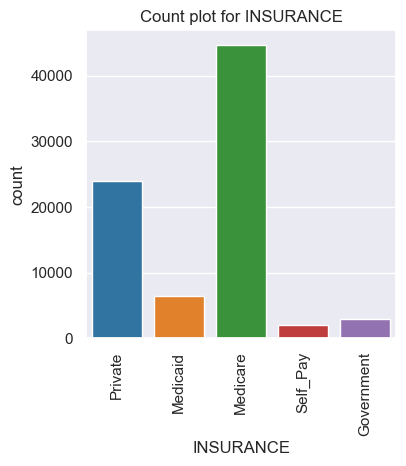

LANGUAGE
ENGL      0.947
SPAN     0.0109
RUSS    0.00728
PTUN    0.00693
CANT    0.00383
         ...   
SERB      5e-05
*LIT      5e-05
*FAR   3.75e-05
*YID   3.75e-05
*PHI   3.75e-05
Name: proportion, Length: 68, dtype: float64


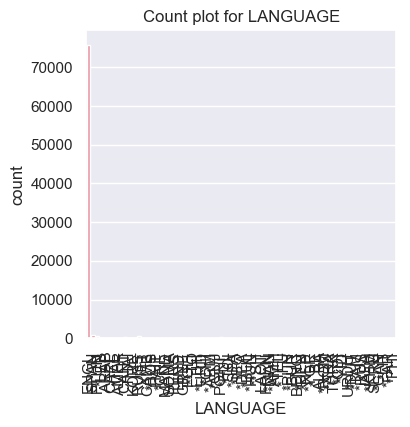

RELIGION
CATHOLIC              0.38
NOT_SPECIFIED        0.189
OTHER                 0.12
UNOBTAINABLE          0.11
PROTESTANT_QUAKER    0.109
JEWISH              0.0925
Name: proportion, dtype: float64


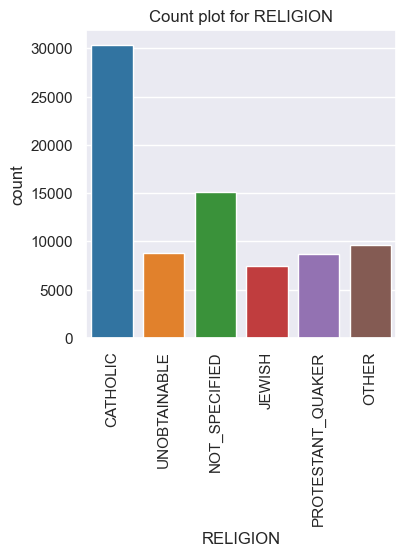

MARITAL_STATUS
MARRIED              0.546
SINGLE               0.229
WIDOWED              0.117
DIVORCED            0.0627
UNKNOWN_(DEFAULT)   0.0264
SEPARATED           0.0142
LIFE_PARTNER        0.0047
Name: proportion, dtype: float64


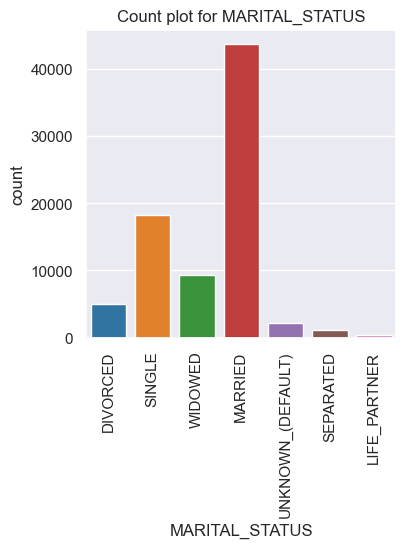

ETHNICITY
WHITE                                                         0.747
UNKNOWN/NOT_SPECIFIED                                        0.0543
BLACK/AFRICAN_AMERICAN                                       0.0465
OTHER                                                        0.0206
HISPANIC_OR_LATINO                                           0.0179
ASIAN                                                        0.0177
UNABLE_TO_OBTAIN                                             0.0173
PATIENT_DECLINED_TO_ANSWER                                   0.0136
ASIAN_-_CHINESE                                             0.00676
HISPANIC/LATINO_-_PUERTO_RICAN                              0.00583
BLACK/CAPE_VERDEAN                                          0.00533
WHITE_-_RUSSIAN                                             0.00491
MULTI_RACE_ETHNICITY                                        0.00446
HISPANIC/LATINO_-_DOMINICAN                                 0.00363
BLACK/HAITIAN                         

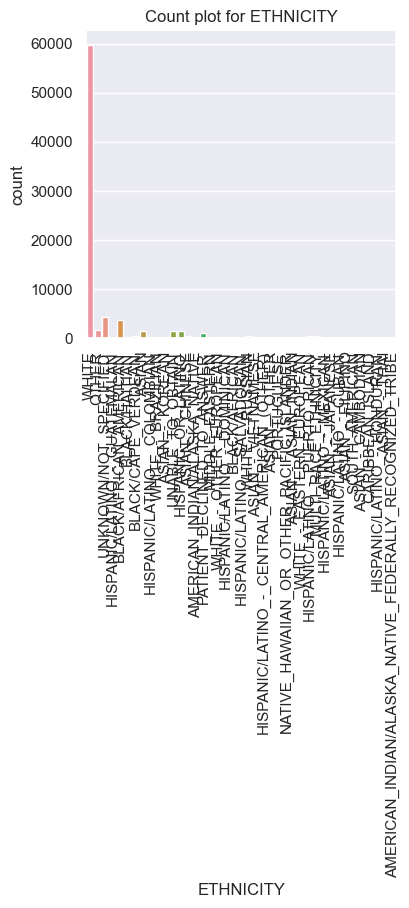

ICU
MICU    0.347
CSRU     0.21
SICU     0.16
CCU     0.147
TSICU   0.136
Name: proportion, dtype: float64


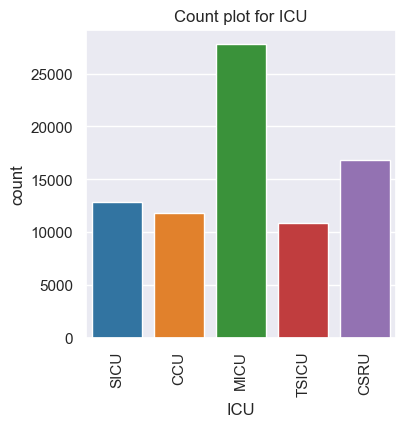

In [25]:
categorical_columns=[]
for col in x_df.columns:
    if types[col]=='Categorical':
        categorical_columns.append(col)
        print(x_df[col].value_counts(normalize=True))
        plt.figure(figsize=(4, 4))
        sns.countplot(data=x_df, x=col)
        plt.title(f'Count plot for {col}')
        plt.xticks(rotation=90)
        plt.show()
 

In [26]:
#Les categories qui ont une frequence moins à 7% on les groupes

In [27]:
columns_to_group=['ETHNICITY', 'MARITAL_STATUS', 'INSURANCE', 'LANGUAGE']
to_keep_and_cgroup=[]
threshold=0.07
for col in columns_to_group:
    value_counts=x_df[col].value_counts(normalize=True)
    tokeep=len(value_counts[value_counts > threshold])
    to_keep_and_cgroup.append((col, tokeep))

In [28]:
for col in to_keep_and_cgroup:
    #print("col0: "+str(col[0])+"col1 "+str(col[1]))
    merge_rare_categories([x_df, x_test_df], col=col[0], keep_n=col[1])

Index(['WHITE'], dtype='object', name='ETHNICITY')
Index(['MARRIED', 'SINGLE', 'WIDOWED'], dtype='object', name='MARITAL_STATUS')
Index(['Medicare', 'Private', 'Medicaid'], dtype='object', name='INSURANCE')
Index(['ENGL'], dtype='object', name='LANGUAGE')


ETHNICITY
WHITE   0.747
OTHER   0.253
Name: proportion, dtype: float64


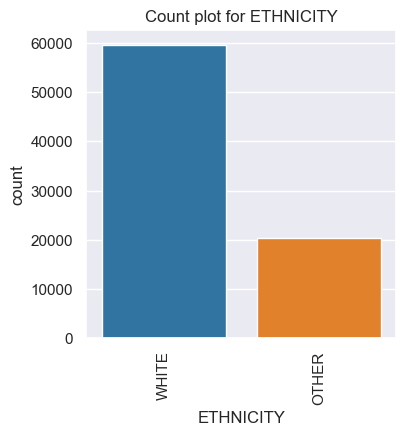

MARITAL_STATUS
MARRIED   0.546
SINGLE    0.229
WIDOWED   0.117
OTHER     0.108
Name: proportion, dtype: float64


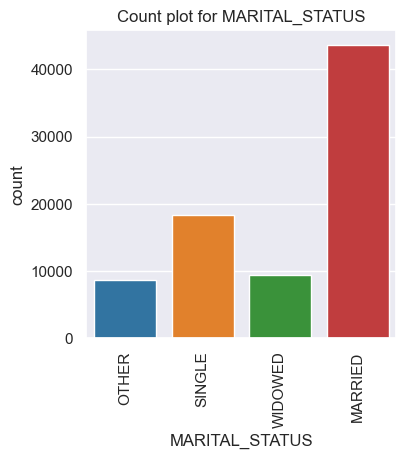

INSURANCE
Medicare    0.558
Private       0.3
Medicaid   0.0804
OTHER      0.0616
Name: proportion, dtype: float64


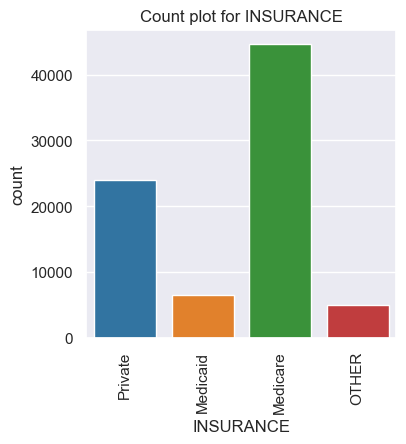

LANGUAGE
ENGL     0.947
OTHER   0.0533
Name: proportion, dtype: float64


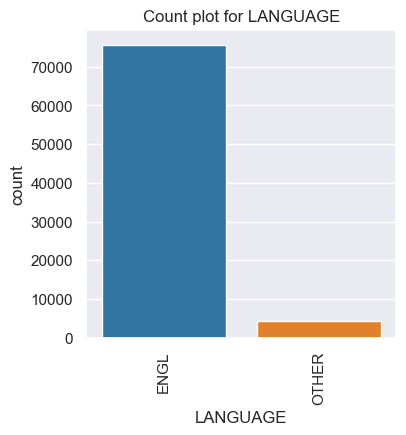

In [29]:
for col in columns_to_group:
    print(x_df[col].value_counts(normalize=True))
    plt.figure(figsize=(4, 4))
    sns.countplot(data=x_df, x=col)
    plt.title(f'Count plot for {col}')
    plt.xticks(rotation=90)
    plt.show()

### Transformation des données catégorielles en nombres entiers en utilisant deux types d'encodage

In [30]:
def label_encode(df, other_df, only_binary=False):
    """
    Select categorical variables and encode them in integers.
    """
    char_cols = df.dtypes.pipe(lambda x: x[x == "object"]).index
    #print(char_cols)

    for col in char_cols:
        n_categories = len(x_df[col].unique())

        if not only_binary or n_categories == 2:
            codes, uniques = pd.factorize(df[col])
            df[col] = codes

            # Create conversion dic to convert values of test set as well
            cat2code = {k: v for v, k in enumerate(uniques)}
            other_df[col] = other_df[col].map(cat2code)

In [31]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,OTHER,WHITE,F,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,OTHER,CATHOLIC,WIDOWED,OTHER,M,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


In [32]:
print(x_df.shape, ys.shape)

(79999, 337) (79999,)


In [33]:
x_fact_df = x_df.copy()
x_test_fact_df = x_test_df.copy()

label_encode(x_fact_df, x_test_fact_df)

In [34]:
x_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,0,0,0,0,0,0,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,2,1,1,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


In [35]:
x_test_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,3,0,5,3,0,0,18,72.6,113,96.5,...,0,0,0,0,0,0,0,0,0,0
1,2,0,2,1,1,0,56,66.6,107,83.8,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0,1,32,69.7,103,87.3,...,0,0,0,0,0,0,0,0,0,0


#### Encodage 1-Hot

Un autre type d'encodage est souvent plus efficace, il a notamment l'avantage de ne pas ordonner les classes d'une manière particulière (pas forcément en adéquation avec la proximité de ces classes entre elles).

Une méthode de pandas permet de le réaliser en 1 ligne de code avec la fonction `get_dummies`.

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

In [36]:
# Encode binary features on a single column (no need for 1-hot)
label_encode(x_df, x_test_df, only_binary=True)

x_all_1h_df = pd.get_dummies(pd.concat([x_df, x_test_df]))

x_1h_df = x_all_1h_df.iloc[: len(x_df)].copy()
x_test_1h_df = x_all_1h_df.iloc[len(x_df):].copy()

print(x_df.shape, x_test_df.shape)
print(x_1h_df.shape, x_test_1h_df.shape)

(79999, 337) (20001, 337)
(79999, 352) (20001, 352)


#### Suppression des variables à valeur unique (constantes)

In [37]:
const_cols = {col for col in x_1h_df if len(x_1h_df[col].unique()) == 1}
len(const_cols)

173

In [38]:
x_1h_df.drop(const_cols, axis="columns", inplace=True)
x_test_1h_df.drop(const_cols, axis="columns", inplace=True)

print(x_1h_df.shape, x_test_1h_df.shape)

(79999, 179) (20001, 179)


In [39]:
correlated_features = set()
correlation_matrix = x_1h_df.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)


x_1h_df.drop(labels=correlated_features, axis=1, inplace=True)
x_test_1h_df.drop(labels=correlated_features, axis=1, inplace=True)

In [40]:
# x_test_1h_df = x_all_1h_df.iloc[len(x_df):].copy()
# x_test_1h_df.drop(const_cols, axis="columns", inplace=True)
# x_test_1h_df.drop(labels=correlated_features, axis=1, inplace=True)

In [41]:


print(x_1h_df.shape, x_test_1h_df.shape)

(79999, 173) (20001, 173)


### Création de l'ensemble de validation

In [42]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    x_1h_df, ys, test_size=0.3
)
# VARS: x_df, x_fact_df, x_1h_df

In [43]:
x_1h_df

,LANGUAGE,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,SYS_BP_MIN_DAY1,SYS_BP_MAX_DAY1,SYS_BP_MEAN_DAY1,DIAS_BP_MIN_DAY1,...,RELIGION_UNOBTAINABLE,MARITAL_STATUS_MARRIED,MARITAL_STATUS_OTHER,MARITAL_STATUS_SINGLE,MARITAL_STATUS_WIDOWED,ICU_CCU,ICU_CSRU,ICU_MICU,ICU_SICU,ICU_TSICU
0,0,0,0,21,57.2,109,79.8,120,94.4,26.9,...,False,False,True,False,False,False,False,False,True,False
1,0,0,1,39,79.3,121,94,139,114,38.6,...,True,False,False,True,False,True,False,False,False,False
2,1,1,1,40,118,175,123,144,135,67.8,...,False,False,False,False,True,False,False,True,False,False
3,0,0,1,75,83.8,89.2,111,145,128,61.1,...,False,True,False,False,False,True,False,False,False,False
4,0,1,0,55,60.9,106,87.6,128,99.1,42.7,...,True,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79994,0,0,0,76,56,97.9,77.5,120,102,26.7,...,False,False,True,False,False,False,True,False,False,False
79995,0,0,0,38,55.1,86,83.1,175,119,40.4,...,False,True,False,False,False,False,False,False,False,True
79996,0,0,0,90,74.3,91.3,95.9,139,131,52.7,...,False,False,True,False,False,False,False,False,True,False
79997,0,1,1,57,79.3,129,108,142,132,57.1,...,False,True,False,False,False,False,False,False,False,True


### Réduction de la dimension via l'ACP (PCA)

In [44]:
#Normalisation avec StandardScaler
scaler = preprocessing.StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

x_valid_scaled = scaler.transform(x_valid)

assert(abs(np.mean(x_train_scaled))<0.01)
assert(abs(np.mean(x_valid_scaled))<0.01)

print("Description de x_train:\n")
print("\tMean:", np.mean(x_train))
print("\tMaximum:", np.max(x_train))
print("\tMinimum:", np.min(x_train))
print("\n\nDescription de x_valid:\n")
print("\tMean:", np.mean(x_valid))
print("\tMaximum:", np.max(x_valid))
print("\tMinimum:", np.min(x_valid))

Description de x_train:

	Mean: 19.757104917710183
	Maximum: 728.1949
	Minimum: 0


Description de x_valid:

	Mean: 19.755154641537555
	Maximum: 748.4762
	Minimum: 0


In [45]:
def plot_points(xs, ys, ft_names=(None, None), target_names=None, colors=None):
    if target_names is None:
        target_names = {}
    if colors is None:
        colors = {}

    for y_val in set(ys):
        plt.scatter(
            xs[ys == y_val, 0],
            xs[ys == y_val, 1],
            color=colors.get(y_val),
            alpha=0.8,
            label=target_names.get(y_val),
            edgecolor="black",
        )
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.title("3-Class classification")
    try:
        plt.xlabel(ft_names[0])
        plt.ylabel(ft_names[1])
    except TypeError:
        pass

In [46]:
def plot_points3D(xs, ys, ft_names=(None, None), target_names=None, colors=None):
    if target_names is None:
        target_names = {}
    if colors is None:
        colors = {}

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for y_val in set(ys):
        ax.scatter(
            xs[ys == y_val, 0],
            xs[ys == y_val, 1],
            xs[ys == y_val, 2],  # Third dimension
            color=colors.get(y_val),
            alpha=0.8,
            label=target_names.get(y_val),
            edgecolor="black",
        )
    
    ax.legend(loc="best", shadow=False, scatterpoints=1)
    ax.set_title("3-Class classification")
    try:
        ax.set_xlabel(ft_names[0])
        ax.set_ylabel(ft_names[1])
        ax.set_zlabel(ft_names[2])  # Third dimension label
    except TypeError:
        pass
    ax.set_zlabel('Z-Axis', rotation=90)
    plt.show()

In [47]:
# TODO: PCA
pca = PCA(n_components = 2)

x_train_reduced = pca.fit_transform(x_train_scaled)

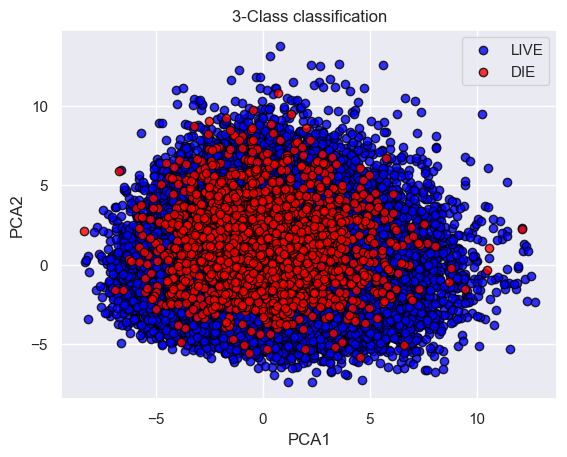

In [48]:
COLORS = {0: "blue", 1: "red"}

labels = (ys == 0)  

target_names = {k: 'LIVE' if k == 0 else 'DIE' for k in ys.unique()}


plot_points(x_train_reduced, y_train, ["PCA1", "PCA2"], target_names, COLORS)

comme on voie dans le graphique, PCA avec 2 composantes nous a donnée une mauvaise distribution des données, les points rouges superposent les points
en bleu, c'est ambigue, donc on peut dire que la réduction à 2 dimensions cause un undersampling des données.

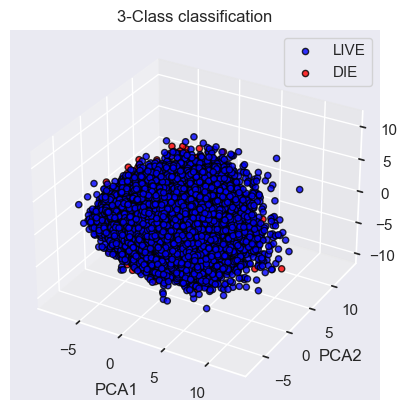

In [49]:
#%matplotlib
# Create an instance of PCA with 3 components
pca = PCA(n_components=3)

# Fit and transform the normalized data
x_train_reduced = pca.fit_transform(x_train_scaled)
plot_points3D(x_train_reduced, y_train, ["PCA1", "PCA2", "PCA3"], target_names, COLORS)

In [50]:
#On affiche la courbe de la variance pou pouvoir choisir la meuilleur dimension pour tout les models

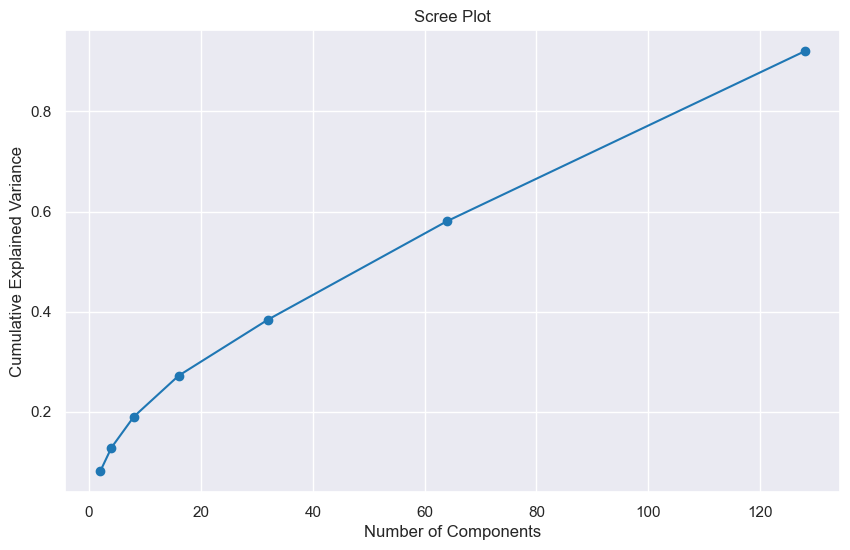

In [51]:
# Fit PCA with different numbers of components
explained_variance = []
for n_components in [2, 4, 8, 16, 32, 64, 128]:
    pca = PCA(n_components=n_components)
    pca.fit(x_train_scaled)
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

# Plot the scree plot
plt.figure(figsize=(10, 6))
plt.plot( [2, 4, 8, 16, 32, 64, 128], explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()


In [52]:
best_n_components = 128  # You obtained this from grid_search.best_params_
pca = PCA(n_components=best_n_components)
# Transform the training data to the reduced-dimensional space
pca.fit(x_train_scaled)

# Transform training and validation data
x_train_reduced = pca.transform(x_train_scaled)
x_valid_reduced = pca.transform(x_valid_scaled)
print("application PCA: "+str(x_train_reduced.shape))

application PCA: (55999, 128)


Elbow point = 128 components

## 5. Modèles de classification (sans l'outil SMOT)

### Baseline

`LogisticRegression` or `RandomForestClassifier`

In [53]:
SCORINGS = "balanced_accuracy"

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, balanced_accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


In [55]:
# Initialize the RandomForestClassifier with 10 trees
rf_classifier = RandomForestClassifier(n_estimators=10)

# Entraînement du classifieur sur l'ensemble d'entraînement
rf_classifier.fit(x_train_reduced, y_train) 

RandomForestClassifier(n_estimators=10)

In [56]:
# Spécifier les hyperparamètres
C_value = 0.001

# Créer une instance de LogisticRegression avec les hyperparamètres spécifiés
lr_classifier = LogisticRegression(C=C_value)

# Entraînement du classifieur sur l'ensemble d'entraînement sur-échantillonné
lr_classifier.fit(x_train_reduced, y_train)

LogisticRegression(C=0.001)

## 6. Évaluations (sans SMOT)

In [57]:
#LogisticRegression :

In [58]:
from sklearn.metrics import balanced_accuracy_score

# Faire des prédictions sur l'ensemble de validation ou de test
y_pred = lr_classifier.predict(x_valid_reduced)

# Calculer la balanced_accuracy
balanced_acc = balanced_accuracy_score(y_valid, y_pred)

# Afficher la balanced_accuracy
print("Balanced Accuracy:", balanced_acc)

Balanced Accuracy: 0.5010966145667458


In [59]:
#RandomForestClassifier : 

In [60]:
from sklearn.metrics import balanced_accuracy_score

# Faire des prédictions sur l'ensemble de validation ou de test
y_pred = rf_classifier.predict(x_valid_reduced)

# Calculer la balanced_accuracy
balanced_acc = balanced_accuracy_score(y_valid, y_pred)

# Afficher la balanced_accuracy
print("Balanced Accuracy:", balanced_acc)

Balanced Accuracy: 0.5002998090768817


## 5. Modèles de classification (avec SMOT)

Entrainez le modèle

In [61]:
from imblearn.over_sampling import SMOTE

# Sur-échantillonnage avec SMOTE
smote = SMOTE(random_state=42)
x_train_ov, y_train_ov = smote.fit_resample(x_train_reduced, y_train)
print(y_train_ov.value_counts())
print(x_train_ov.shape)

0    54063
1    54063
Name: count, dtype: int64
(108126, 128)


In [62]:
from imblearn.under_sampling import RandomUnderSampler

# Define the undersampler
undersampler = RandomUnderSampler(random_state=42)

# Apply undersampling to your data
x_train_us, y_train_us = undersampler.fit_resample(x_train_reduced, y_train)
print(y_train_us.value_counts())
print(x_train_us.shape)

0    1936
1    1936
Name: count, dtype: int64
(3872, 128)


In [63]:
# Initialize the RandomForestClassifier with 10 trees
rf_classifier = RandomForestClassifier(n_estimators=10)

# Entraînement du classifieur sur l'ensemble d'entraînement
rf_classifier.fit(x_train_ov, y_train_ov) 

pred_test_rbt = rf_classifier.predict(x_valid_reduced)
resultat = balanced_accuracy_score(y_valid, pred_test_rbt)
print(resultat)

0.5301486562123497


In [64]:
# Initialize the RandomForestClassifier with 10 trees
rf_classifier = RandomForestClassifier(n_estimators=10)

# Entraînement du classifieur sur l'ensemble d'entraînement
rf_classifier.fit(x_train_us, y_train_us) 

pred_test_rbt = rf_classifier.predict(x_valid_reduced)
resultat = metrics.balanced_accuracy_score(y_valid, pred_test_rbt)
print(resultat)

0.6267999650047065


In [65]:
C_value = 0.01

# Créer une instance de LogisticRegression avec les hyperparamètres spécifiés
lr_classifier = LogisticRegression(C=C_value)

# Entraînement du classifieur sur l'ensemble d'entraînement sur-échantillonné
lr_classifier.fit(x_train_ov, y_train_ov)
pred_test_rbt = lr_classifier.predict(x_valid_reduced)
resultat = metrics.balanced_accuracy_score(y_valid, pred_test_rbt)
print(resultat)

0.7246474984614268


In [66]:
C_value = 0.01

# Créer une instance de LogisticRegression avec les hyperparamètres spécifiés
lr_classifier = LogisticRegression(C=C_value)

# Entraînement du classifieur sur l'ensemble d'entraînement sur-échantillonné
lr_classifier.fit(x_train_us, y_train_us)
pred_test_rbt = lr_classifier.predict(x_valid_reduced)
resultat = metrics.balanced_accuracy_score(y_valid, pred_test_rbt)
print(resultat)

0.7238180919343227


In [67]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score

# Initialize MLPClassifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, ), max_iter=1000)

# Train the MLPClassifier on the training data
mlp_classifier.fit(x_train_us, y_train_us)

# Predict on the validation set
y_pred = mlp_classifier.predict(x_valid_reduced)

# Calculate balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_valid, y_pred)
print("Balanced Accuracy:", balanced_accuracy)


Balanced Accuracy: 0.6933017140917644


In [68]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import balanced_accuracy_score

# Initialize SGDClassifier for linear SVM
svm_classifier = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3)

# Train the SVM classifier on the training data
svm_classifier.fit(x_train_ov, y_train_ov)

# Predict on the validation set
y_pred = svm_classifier.predict(x_valid_reduced)

# Calculate balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_valid, y_pred)
print("Balanced Accuracy:", balanced_accuracy)

Balanced Accuracy: 0.7188592708842019


In [69]:
import xgboost as xgb


xgboost = xgb.XGBClassifier(    
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1)
xgboost.fit(x_train_ov, y_train_ov)

# Making predictions on the testing data
y_pred = xgboost.predict(x_valid_reduced)

balanced_accuracy = balanced_accuracy_score(y_valid, y_pred)
print("Balanced Accuracy:", balanced_accuracy)


Balanced Accuracy: 0.6687910797538825


## 6. Évaluations

In [70]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.metrics import classification_report_imbalanced
def metrics (model, name):
    # Faire des prédictions sur l'ensemble de validation ou de test
    y_pred = model.predict(x_valid_reduced)

    # Calculer la balanced_accuracy
    balanced_acc = balanced_accuracy_score(y_valid, y_pred)

    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_pred)
    balanced_acc = balanced_accuracy_score(y_valid, y_pred)
    print(name)
    print("\tAccuracy:", accuracy)
    print("\tPrecision:", precision)
    print("\tRecall:", recall)
    print("\tF1 Score:", f1)
    print("\tROC AUC Score:", roc_auc)
    print("\tBalanced Accuracy:", balanced_acc)

    # You can also use classification_report_imbalanced for a comprehensive report
    print("Classification Report (Imbalanced):")
    print(classification_report_imbalanced(y_valid, y_pred))

In [71]:
metrics(lr_classifier, 'Logistic regression: ')
metrics(rf_classifier, 'Random Forest :')
metrics(xgboost, 'XG_Boost')
metrics(svm_classifier, 'SVM classifier')
metrics(mlp_classifier, 'MLP classifier')

Logistic regression: 
	Accuracy: 0.7240416666666667
	Precision: 0.08889840182648402
	Recall: 0.7235772357723578
	F1 Score: 0.15834286440462575
	ROC AUC Score: 0.7238180919343228
	Balanced Accuracy: 0.7238180919343227
Classification Report (Imbalanced):
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.72      0.72      0.83      0.72      0.52     23139
          1       0.09      0.72      0.72      0.16      0.72      0.52       861

avg / total       0.95      0.72      0.72      0.81      0.72      0.52     24000

Random Forest :
	Accuracy: 0.7105416666666666
	Precision: 0.0659058487874465
	Recall: 0.5365853658536586
	F1 Score: 0.11739296150425613
	ROC AUC Score: 0.6267999650047065
	Balanced Accuracy: 0.6267999650047065
Classification Report (Imbalanced):
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.72      0.54      0.83      0.62      0.39     23139

### Code : Validation croisée

In [72]:
CV = 5

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

def plot_validation_curve(estimator, X, y, param_name, param_range, cv, scoring, title=None, xlabel=None, ylabel=None):

    # Compute validation curve
    train_scores, test_scores = validation_curve(
        estimator=estimator,
        X=X,
        y=y,
        param_name=param_name,
        param_range=param_range,
        cv=cv,
        scoring=scoring
    )

    # Calculate mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot validation curve
    plt.figure(figsize=(10, 6))
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="blue", marker='o')
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="blue")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="red", marker='o')
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="red")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Définir la grille de paramètres à tester
param_grid = {
    'C': [1, 8, 9, 10]  # Paramètre de régularisation
}

# Initialiser GridSearchCV avec le modèle de régression logistique, la grille de paramètres, le nombre de validations croisées et la métrique
grid_search = GridSearchCV(estimator=lr_classifier, param_grid=param_grid, cv=CV, scoring=SCORINGS)

# Exécuter la recherche sur la grille
grid_search.fit(x_train_ov, y_train_ov)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs hyperparamètres:")
print(grid_search.best_params_)

# Afficher la meilleure balanced_accuracy obtenue
print("Meilleure Balanced Accuracy:", grid_search.best_score_)

Meilleurs hyperparamètres:
{'C': 8}
Meilleure Balanced Accuracy: 0.7714147640004859


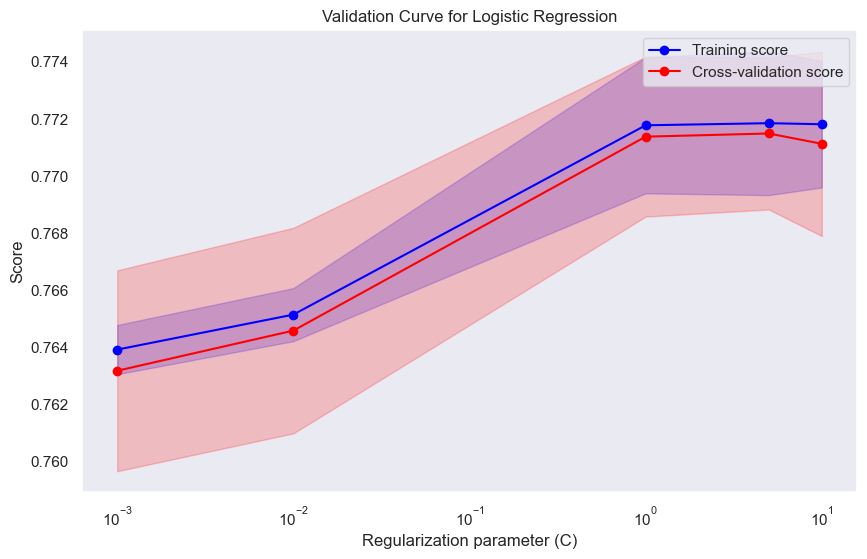

In [75]:
plot_validation_curve(
    estimator=lr_classifier,
    X=x_train_ov,
    y=y_train_ov,
    param_name="C",
    param_range=[0.001, 0.01, 1, 5, 10],
    cv=CV,
    scoring=SCORINGS,
    title="Validation Curve for Logistic Regression",
    xlabel="Regularization parameter (C)",
    ylabel="Score"
)

In [76]:
# Définir la grille de paramètres à tester
param_grid = {
    'n_estimators': [10, 20, 100]
}

# Initialiser GridSearchCV avec le modèle RandomForestClassifier, la grille de paramètres, le nombre de validations croisées et la métrique
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=CV, scoring=SCORINGS)

# Exécuter la recherche sur la grille
grid_search.fit(x_train_reduced, y_train)
# Afficher les meilleurs paramètres trouvés
print("Meilleurs hyperparamètres:")
print(grid_search.best_params_)

# Afficher la meilleure balanced_accuracy obtenue
print("Meilleure Balanced Accuracy:", grid_search.best_score_)

Meilleurs hyperparamètres:
{'n_estimators': 10}
Meilleure Balanced Accuracy: 0.5007270596087616


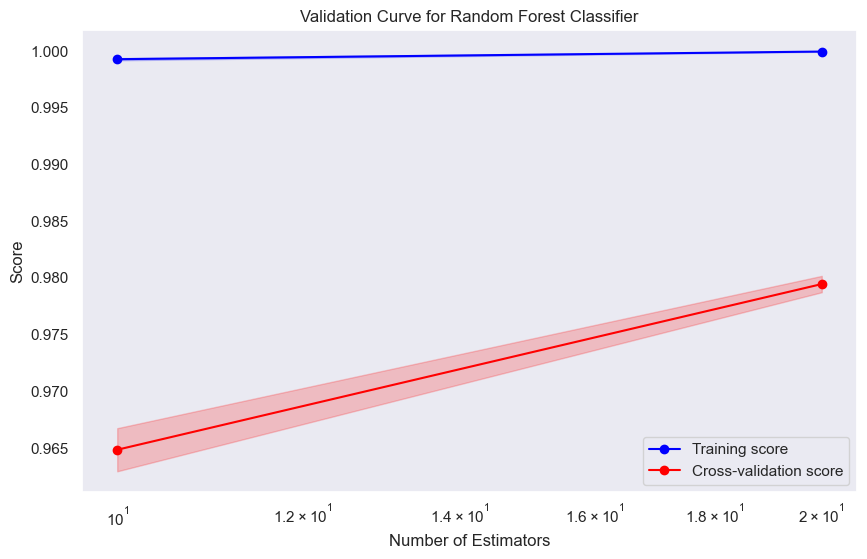

In [89]:
plot_validation_curve(
    estimator=rf_classifier,
    X=x_train_ov,
    y=y_train_ov,
    param_name="n_estimators",
    param_range=[10, 20],
    cv=CV,
    scoring=SCORINGS,
    title="Validation Curve for Random Forest Classifier",
    xlabel="Number of Estimators",
    ylabel="Score"
)

In [90]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

# Define the parameter grid
param_grid = {
    'alpha': [0.0001, 0.01, 0.01, 10,100,150,170,180],
}


# Initialize GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring=SCORINGS)

# Fit the grid search to the data
grid_search.fit(x_train_ov, y_train_ov)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'alpha': 0.01}
Best Score: 0.7637661915360031


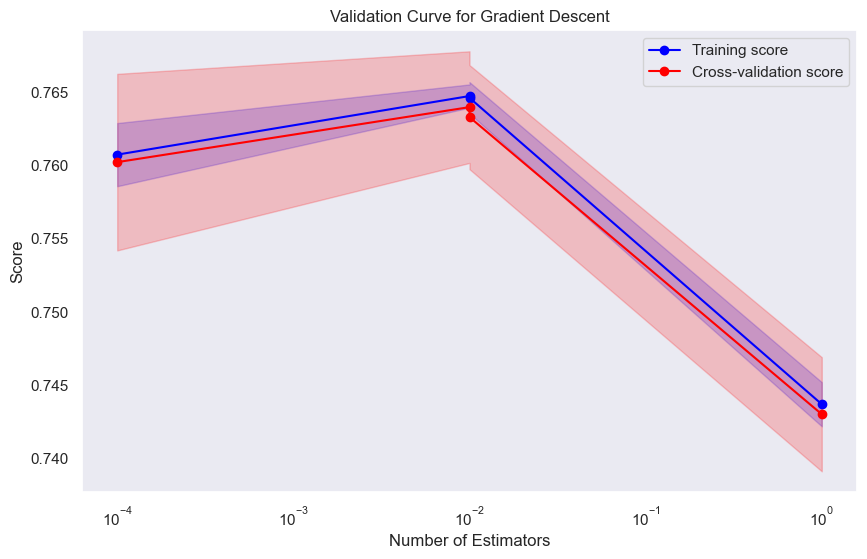

In [91]:
plot_validation_curve(
    estimator=svm_classifier,
    X=x_train_ov,
    y=y_train_ov,
    param_name="alpha",
    param_range=[0.0001, 0.01, 0.01, 1],
    cv=CV,
    scoring=SCORINGS,
    title="Validation Curve for Gradient Descent",
    xlabel="Number of Estimators",
    ylabel="Score"
)

In [92]:
#comparer les models : 
nbc_list = [10,100,150,170,180]
bacc_by_model=[]
Classifiers=[lr_classifier, svm_classifier]
for model in Classifiers:
    bacc_by_nbc=[]
    for nbc in nbc_list:
        pipe = imblearn.pipeline.Pipeline(
        [
            ('threshold', feature_selection.VarianceThreshold(threshold=0.01)),
            ("model",model)
        ]
        )
        scores = model_selection.cross_val_score(pipe, x_train_ov, y_train_ov, cv=2, scoring=SCORINGS)
        with np.printoptions(precision=2):
            bacc_by_nbc.append(scores)
    bacc_by_model.append(bacc_by_nbc)
bacc_by_model


[[array([0.763, 0.765]),
  array([0.763, 0.765]),
  array([0.763, 0.765]),
  array([0.763, 0.765]),
  array([0.763, 0.765])],
 [array([0.762, 0.767]),
  array([0.761, 0.758]),
  array([0.759, 0.762]),
  array([0.76 , 0.756]),
  array([0.757, 0.755])]]

LogisticRegression(C=0.01)


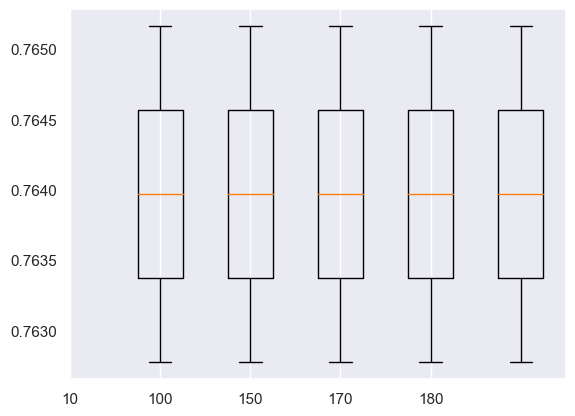

SGDClassifier()


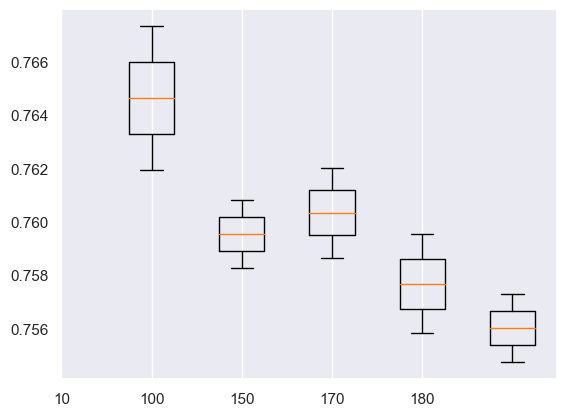

In [93]:
# TODO: Boxplot ou Barplot
i=0
for model in Classifiers: # model names
    print(model) 
    plt.boxplot(bacc_by_model[i])
    plt.xticks([i  for i in range(len(nbc_list))], [str(nbc_list[i]) for i in range(len(nbc_list))])
    i+=1
    plt.grid(axis="y")
    plt.show()

### Code : Amélioration du score

In [94]:
from sklearn.metrics import roc_auc_score

# Faire des prédictions sur l'ensemble de validation
y_pred_lr = lr_classifier.predict_proba(x_valid_reduced)[:, 1]

# Calculer l'aire sous la courbe ROC
auc_lr = roc_auc_score(y_valid, y_pred_lr)

print("Aire sous la courbe ROC pour Logistic Regression:", auc_lr)

Aire sous la courbe ROC pour Logistic Regression: 0.7853460370465238


In [95]:
# Faire des prédictions sur l'ensemble de validation
y_pred_rf = rf_classifier.predict_proba(x_valid_reduced)[:, 1]

# Calculer l'aire sous la courbe ROC
auc_rf = roc_auc_score(y_valid, y_pred_rf)

print("Aire sous la courbe ROC pour Random Forest Classifier:", auc_rf)

Aire sous la courbe ROC pour Random Forest Classifier: 0.6739514299256643


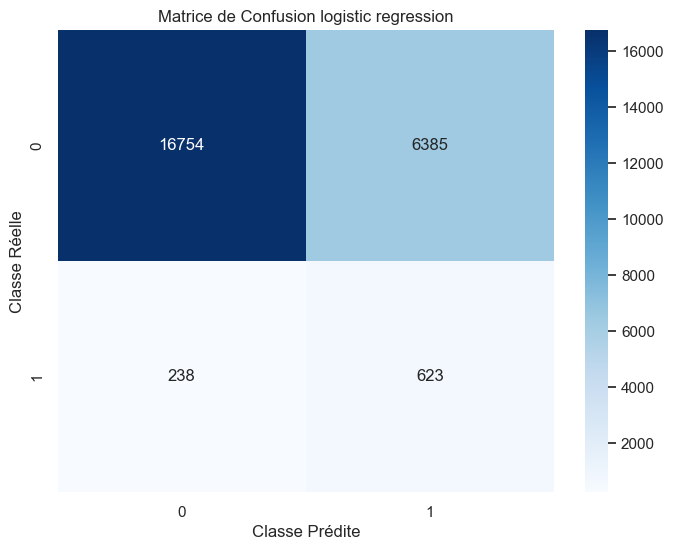

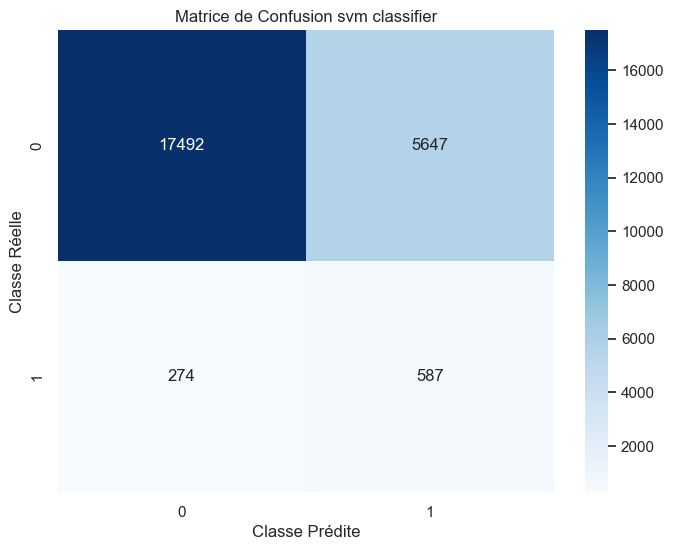

In [96]:
from sklearn.metrics import confusion_matrix

# Faire des prédictions sur les données de validation
y_pred = lr_classifier.predict(x_valid_reduced)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_valid, y_pred)

# Affichage de la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.title('Matrice de Confusion logistic regression')
plt.show()


# Faire des prédictions sur les données de validation
y_pred = svm_classifier.predict(x_valid_reduced)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_valid, y_pred)

# Affichage de la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.title('Matrice de Confusion svm classifier')
plt.show()

In [97]:
x_test_1h_df_scaled=scaler.transform(x_test_1h_df)
x_test_1h_df_reduced=pca.transform(x_test_1h_df_scaled)
print(x_test_1h_df_reduced.shape)

(20001, 128)


In [98]:
#le meuilleur model qu'on a est LogisticRegressor avec un parametres C=8
x_test = x_test_1h_df_reduced
pred_fname = "mimic_synthetic_test.csv"



selected_model = LogisticRegression(C=9)
#selected_model = SGDClassifier(loss='hinge', alpha=0.01, max_iter=1000, tol=1e-3)
selected_model.fit(x_train_ov, y_train_ov)
pred_test_rbt = selected_model.predict(x_test)
predictions = pred_test_rbt



In [99]:
PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")

The submission is ready: Submissions/submission_2024-05-15T15-04-49.zip
